In [1]:
import gc

# построение графиков
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# основные бибилотеки 
import numpy as np
import pandas as pd

#библиотеки для для обучения моделей
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from google.colab import files

#https://www.kaggle.com/camnugent/geospatial-feature-engineering-and-visualization

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Функции

In [0]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [0]:
def nan_analize(X):
    nan_df = (X.isna().sum() / X.shape[0]).reset_index()
    nan_df.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(nan_df['feature'], nan_df['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [0]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 5)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [0]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

# Загрузка данных

In [7]:
uploaded = files.upload() 

for fn in uploaded.keys():
   print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving Data set to test X.csv to Data set to test X.csv
Saving Data set to train.csv to Data set to train.csv
User uploaded file "Data set to test X.csv" with length 451559 bytes
User uploaded file "Data set to train.csv" with length 1041155 bytes


In [8]:
!ls

'Data set to test X.csv'  'Data set to train.csv'   sample_data


In [0]:
df = pd.read_csv('Data set to train.csv')

In [10]:
df

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,5088,-118.28,33.98,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN,121400.0
1,17096,-122.23,37.46,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN,363700.0
2,5617,-118.26,33.79,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN,205600.0
3,20060,-119.26,35.87,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND,47600.0
4,895,-121.96,37.54,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN,236000.0
...,...,...,...,...,...,...,...,...,...,...,...
13823,11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700,<1H OCEAN,229200.0
13824,11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500,INLAND,97800.0
13825,5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344,<1H OCEAN,222100.0
13826,860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,<1H OCEAN,283500.0


In [11]:
df.head(7)

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,5088,-118.28,33.98,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN,121400.0
1,17096,-122.23,37.46,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN,363700.0
2,5617,-118.26,33.79,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN,205600.0
3,20060,-119.26,35.87,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND,47600.0
4,895,-121.96,37.54,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN,236000.0
5,19653,-120.85,37.49,39.0,2840.0,733.0,2606.0,737.0,1.9429,INLAND,76400.0
6,18403,-121.84,37.24,24.0,7991.0,1286.0,4017.0,1213.0,5.4741,<1H OCEAN,238800.0


In [12]:
df.columns

Index(['Id ', 'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_house_value'],
      dtype='object')

In [14]:
# мы будем предсказывать median_house_value 

X = df.drop('median_house_value', axis=1)
y = df[['Id ', 'median_house_value']]

# X --> y : F
# y = F(X)

X_final = pd.read_csv('Data set to test X.csv')

# X_final --> ?
# y_final_ваш = F(X_final)
# y_final_true ? y_final_ваш

del df
gc.collect()

14

In [15]:
X.head(5)

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,5088,-118.28,33.98,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN
1,17096,-122.23,37.46,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN
2,5617,-118.26,33.79,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN
3,20060,-119.26,35.87,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND
4,895,-121.96,37.54,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN


In [16]:
y.head(5)

,Id,median_house_value
0,5088,121400.0
1,17096,363700.0
2,5617,205600.0
3,20060,47600.0
4,895,236000.0


In [17]:
X_final.head(5)

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,INLAND
1,3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,INLAND
2,15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,NEAR BAY
3,20484,-118.72,34.28,17.0,3051.0,NaN,NaN,495.0,5.7376,<1H OCEAN
4,9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,NEAR OCEAN


In [0]:
x_index_final = X_final['Id ']

In [0]:
X.set_index("Id ", inplace=True)
y.set_index("Id ", inplace=True)
X_final.set_index("Id ", inplace=True)

In [21]:
X.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
5088,-118.28,33.98,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN
17096,-122.23,37.46,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN
5617,-118.26,33.79,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN
20060,-119.26,35.87,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND
895,-121.96,37.54,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN


In [22]:
X = reduce_mem_usage(X)
y = reduce_mem_usage(y)
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 1.05 MB
Memory usage after optimization is: 0.54 MB
Decreased by 48.7%
Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.16 MB
Decreased by 25.0%
Memory usage of dataframe is 0.52 MB
Memory usage after optimization is: 0.27 MB
Decreased by 48.7%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Логика


*   Загрузка данных
*   Анализ данных
*   Модифкация данных
*   Обучение модели



**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

# Анализ данных

In [35]:
X[['total_rooms', 'population']].head(5)

,total_rooms,population
Id,,
5088,883.0,726.0
17096,2643.0,1015.0
5617,1162.0,1044.0
20060,1590.0,1686.0
895,5106.0,2738.0


In [38]:
X[ (X['longitude'] < -120) & (X['housing_median_age'] < 30) ]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
895,-121.959999,37.540001,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN
18403,-121.839996,37.240002,24.0,7991.0,1286.0,4017.0,1213.0,5.4741,<1H OCEAN
1225,-120.430000,38.250000,13.0,763.0,161.0,311.0,125.0,2.4583,INLAND
3333,-122.620003,38.919998,13.0,520.0,115.0,249.0,109.0,1.8417,INLAND
18816,-120.230003,39.560001,14.0,1781.0,346.0,734.0,287.0,2.4600,INLAND
...,...,...,...,...,...,...,...,...,...
18431,-121.849998,37.259998,16.0,1982.0,280.0,1030.0,297.0,6.4339,<1H OCEAN
18942,-122.080002,38.299999,2.0,6718.0,858.0,2012.0,654.0,6.8872,INLAND
19769,-122.110001,39.820000,27.0,1065.0,214.0,508.0,198.0,2.6250,INLAND


In [57]:
X.describe() #количественные

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000
mean,-119.489861,34.763271,28.584610,2647.572998,540.267151,1423.267578,501.675446,3.876735
std,4.857742,115.936920,12.363278,2171.663818,421.248840,1132.986938,383.638641,1.903102
min,-124.349998,-13534.030273,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.809998,33.939999,18.000000,1455.000000,297.000000,801.000000,280.000000,2.568575
50%,-118.510002,34.270000,29.000000,2139.000000,437.000000,1168.000000,412.000000,3.538750
75%,-118.010002,37.720001,37.000000,3166.000000,648.000000,1710.000000,607.000000,4.756600
max,121.290001,1327.130005,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100


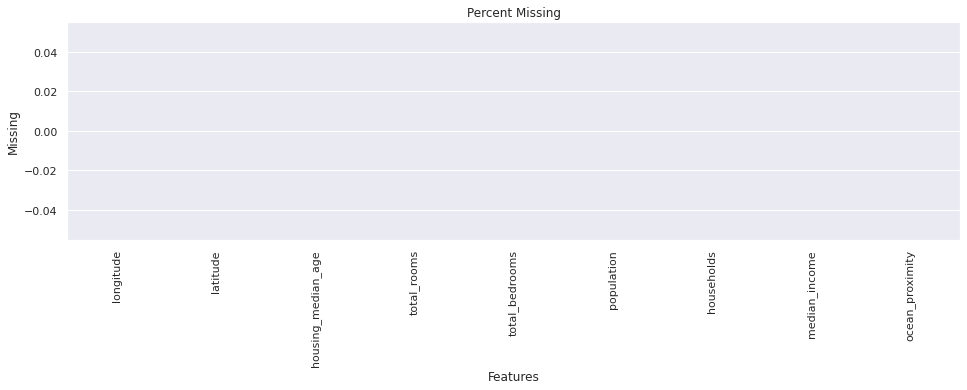

In [56]:
nan_analize(X)

In [41]:
X[X['latitude'] > 1000]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
12772,-121.419998,1327.130005,NaN,2217.0,536.0,1203.0,507.0,1.9412,INLAND


In [43]:
X[X['housing_median_age'] > 50]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
16149,-122.470001,37.770000,52.0,3143.0,635.0,1350.0,623.0,3.8571,NEAR BAY
13732,-117.190002,34.049999,52.0,1949.0,432.0,767.0,392.0,2.5143,INLAND
6775,-118.150002,34.119999,52.0,1518.0,344.0,725.0,296.0,3.4018,<1H OCEAN
4679,-118.339996,34.070000,52.0,1621.0,284.0,588.0,272.0,6.2223,<1H OCEAN
15678,-122.430000,37.799999,52.0,1976.0,726.0,1045.0,669.0,3.6893,NEAR BAY
...,...,...,...,...,...,...,...,...,...
161,-122.250000,37.799999,52.0,2087.0,510.0,1197.0,488.0,3.0149,NEAR BAY
15787,-122.389999,37.790001,52.0,94.0,24.0,113.0,27.0,4.6563,NEAR BAY
17568,-121.930000,37.320000,52.0,1460.0,492.0,1165.0,455.0,2.5833,<1H OCEAN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c4bf6aa90>,
      dtype=object)

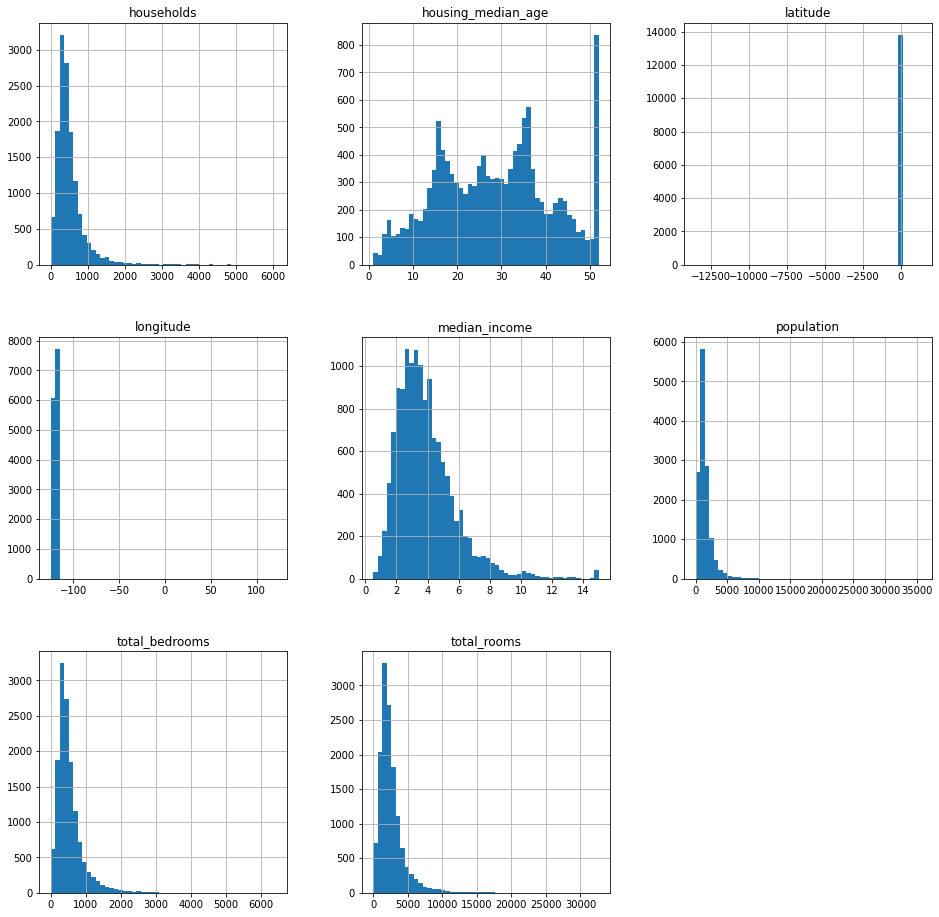

In [42]:
X.hist(figsize=(16,16), bins=50, grid=True)

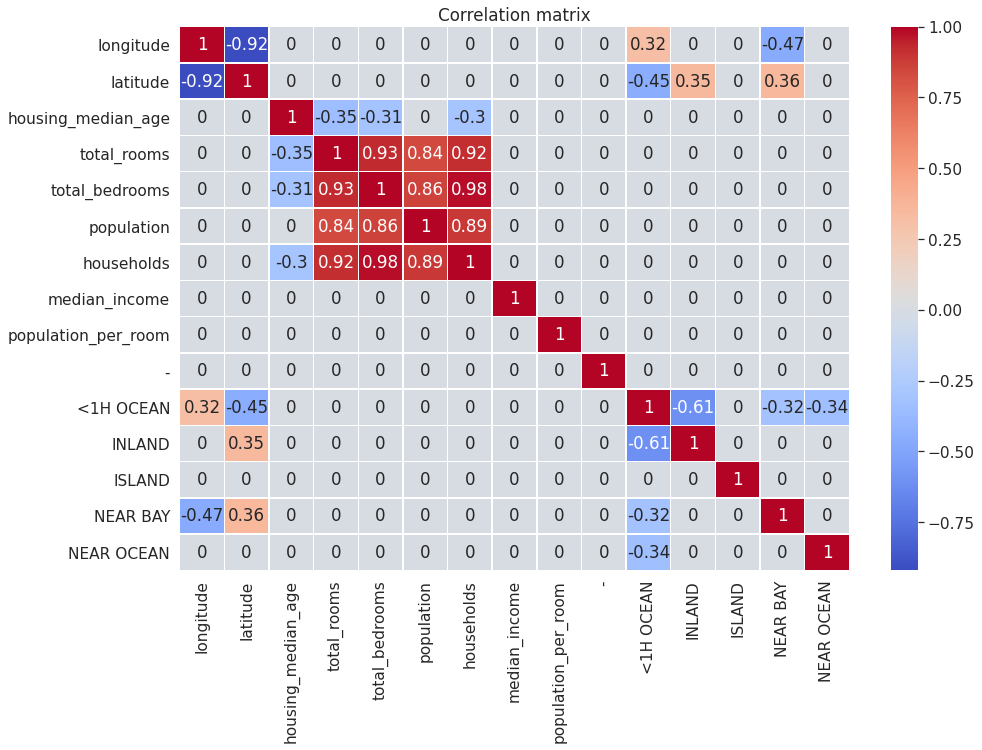

In [97]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

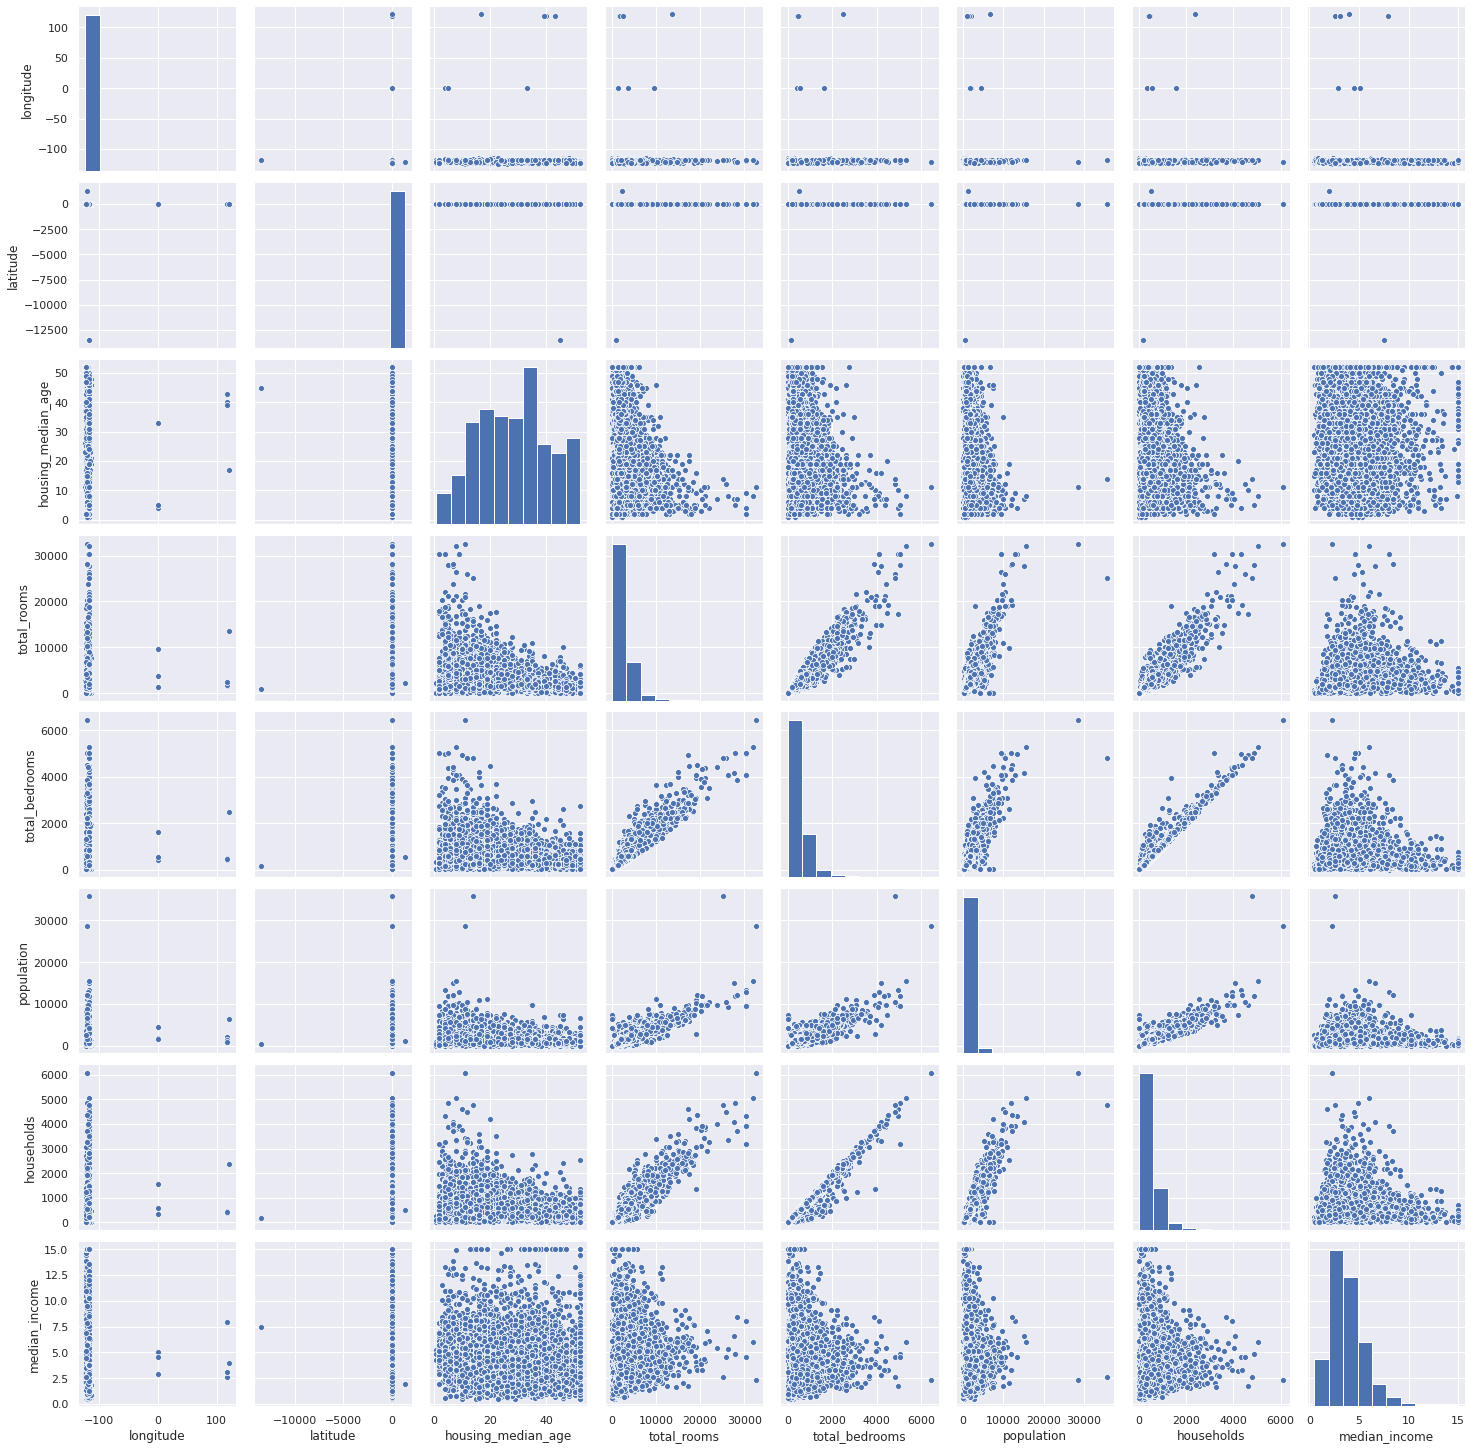

In [47]:
sns.set()
sns.pairplot(X, height = 2.5)
plt.show()

In [48]:
X['ocean_proximity'].value_counts()

<1H OCEAN     6144
INLAND        4414
NEAR OCEAN    1702
NEAR BAY      1552
-               13
ISLAND           3
Name: ocean_proximity, dtype: int64

# Работа с данным

In [0]:
median = X['housing_median_age'].median()
X['housing_median_age'] = X['housing_median_age'].fillna(median)
X_final['housing_median_age'] = X_final['housing_median_age'].fillna(median)

#заполнили проблемы медианами

In [0]:
median = X['population'].median()
X['population'] = X['population'].fillna(median)
X_final['population'] = X_final['population'].fillna(median)

#похоже, надо заполнять не медианам?

In [62]:
X[X['longitude'] > 0]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
8405,118.360001,33.930000,40.0,1625.0,500.0,2036.0,476.0,2.6298,<1H OCEAN
5904,118.430000,34.290001,39.0,1769.0,410.0,1499.0,390.0,3.1212,<1H OCEAN
8636,118.410004,33.880001,43.0,2492.0,449.0,1033.0,437.0,7.9614,<1H OCEAN
13051,121.290001,38.610001,17.0,13553.0,2474.0,6544.0,2359.0,3.9727,INLAND


In [0]:
X.loc[X['longitude'] > 0, 'longitude'] = X.loc[X['longitude'] > 0, 'longitude'] * -1
X_final.loc[X_final['longitude'] > 0, 'longitude'] = X_final.loc[X_final['longitude'] > 0, 'longitude'] * -1

#верно ли сделали?

In [68]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000,13828.000000
mean,-119.558754,34.763271,28.584610,2647.572998,540.267151,1423.267578,501.675446,3.876735
std,2.668684,115.936920,12.363278,2171.663818,421.248840,1132.986938,383.638641,1.903102
min,-124.349998,-13534.030273,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.809998,33.939999,18.000000,1455.000000,297.000000,801.000000,280.000000,2.568575
50%,-118.510002,34.270000,29.000000,2139.000000,437.000000,1168.000000,412.000000,3.538750
75%,-118.010002,37.720001,37.000000,3166.000000,648.000000,1710.000000,607.000000,4.756600
max,0.000000,1327.130005,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100


In [0]:
X.loc[X['longitude'] == 0, 'longitude'] = X['longitude'].median()
X_final.loc[X_final['longitude'] == 0, 'longitude'] = X_final['longitude'].median()

In [0]:
# пятое
median = X['latitude'].median()
X.loc[X['latitude'] < 0, 'latitude'] = median
X_final.loc[X_final['latitude'] < 0, 'latitude'] = median

In [0]:
# пятое
median = X['latitude'].median()
X.loc[X['latitude'] > 1000, 'latitude'] = median
X_final.loc[X_final['latitude'] > 1000, 'latitude'] = median

In [0]:
X['population_per_room'] = X['population'] / X['total_rooms']
X_final['population_per_room'] = X_final['population'] / X_final['total_rooms']

In [81]:
X.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,population_per_room
Id,,,,,,,,,,
5088,-118.279999,33.980000,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN,0.822197
17096,-122.230003,37.459999,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN,0.384033
5617,-118.260002,33.790001,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN,0.898451
20060,-119.260002,35.869999,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND,1.060377
895,-121.959999,37.540001,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN,0.536232


In [90]:
X.drop('total_bedrooms', axis=1)
X_final.drop('total_bedrooms', axis=1)

#точность упала)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity,population_per_room
Id,,,,,,,,,
20046,-119.010002,36.060001,25.0,1505.0,1392.0,359.0,1.6812,INLAND,0.924917
3024,-119.459999,35.139999,30.0,2943.0,1565.0,584.0,2.5313,INLAND,0.531770
15663,-122.440002,37.799999,52.0,3830.0,1310.0,963.0,3.4801,NEAR BAY,0.342037
20484,-118.720001,34.279999,17.0,3051.0,1168.0,495.0,5.7376,<1H OCEAN,0.382825
9814,-121.930000,36.619999,34.0,2351.0,1063.0,428.0,3.7250,NEAR OCEAN,0.452148
...,...,...,...,...,...,...,...,...,...
15316,-117.360001,33.200001,19.0,1926.0,1190.0,483.0,1.3269,NEAR OCEAN,0.617861
14772,-117.070000,32.570000,14.0,1527.0,1224.0,363.0,2.7361,NEAR OCEAN,0.801572
12870,-121.400002,38.709999,15.0,4680.0,2626.0,729.0,3.8355,INLAND,0.561111


In [0]:
X = pd.concat([X, pd.get_dummies(X['ocean_proximity'])], axis=1)
X_final = pd.concat([X_final, pd.get_dummies(X_final['ocean_proximity'])], axis=1)

In [96]:
X.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,population_per_room,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
Id,,,,,,,,,,,,,,,,
5088,-118.279999,33.980000,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN,0.822197,0,1,0,0,0,0
17096,-122.230003,37.459999,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN,0.384033,0,0,0,0,0,1
5617,-118.260002,33.790001,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN,0.898451,0,1,0,0,0,0
20060,-119.260002,35.869999,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND,1.060377,0,0,1,0,0,0
895,-121.959999,37.540001,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN,0.536232,0,1,0,0,0,0


# Обучение

In [98]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'population_per_room', '-', '<1H OCEAN', 'INLAND',
       'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype='object')

In [0]:
#remain_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
#       'total_bedrooms', 'population', 'households', 'median_income']

#remain_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'population', 'households', 'median_income', 'population_per_room']

remain_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income', 'population_per_room', '-', '<1H OCEAN', 'INLAND',
       'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

X_sub = X[remain_features]
X_final_sub = X_final[remain_features]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size=0.3, random_state=42)

#X_train, y_train - то, что используем для обучения
#X_test, y_test - то, что используем для проверки обученного
#X_final - данные без y, которые будем потом использовать для реальный работы

In [113]:
model = LGBMRegressor(max_depth=15, n_estimators=150, random_state=42)
# можно оптимизировать параметры
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=150, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

R2:	0.82995
RMSE:	47398.742
MSE:	2246640767.353


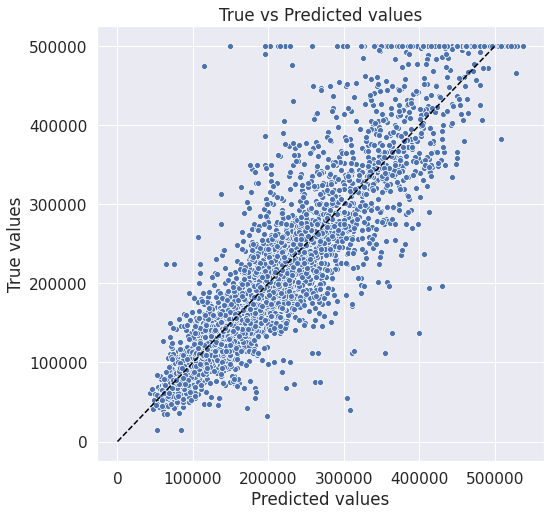

In [114]:
y_pred_test = model.predict(X_test)
evaluate_preds(y_test['median_house_value'], y_pred_test)

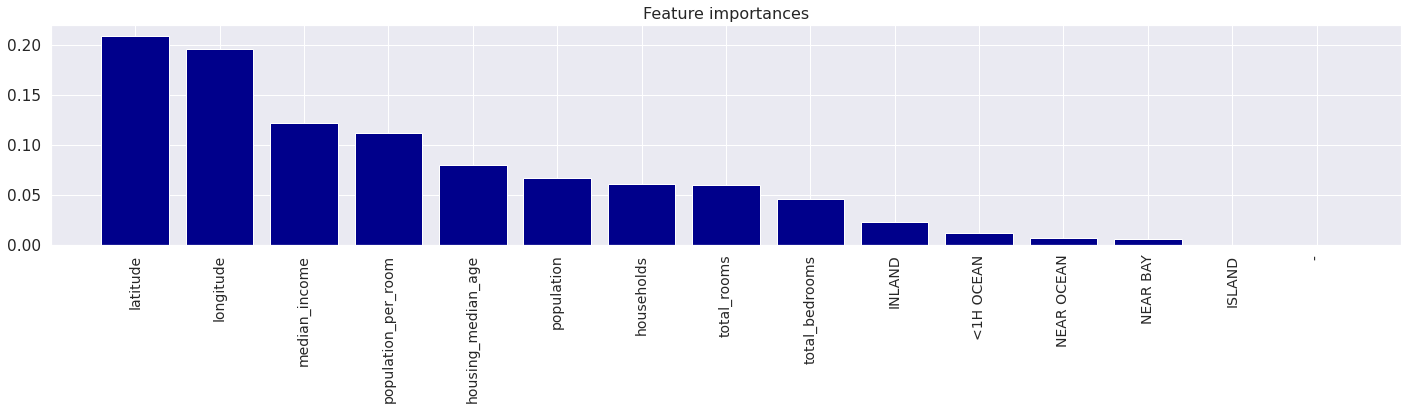

In [115]:
plot_feature_importances(importances=model.feature_importances_, X=X_sub)

# Финал

In [0]:
y_final = model.predict(X_final_sub)

In [120]:
preds_final = pd.DataFrame()
preds_final['Id '] = x_index_final
preds_final['median_house_value'] = y_final

preds_final

,Id,median_house_value
0,20046,79852.840138
1,3024,106098.020873
2,15663,505494.530994
3,20484,366929.918129
4,9814,328128.940626
...,...,...
6807,15316,151438.262929
6808,14772,130997.368278
6809,12870,127741.033689
6810,13476,134551.254448


In [0]:
preds_final.to_csv('First att.csv', index=False, encoding='utf-8')

In [122]:
!ls

'Data set to test X.csv'  'First att.csv'
'Data set to train.csv'    sample_data


In [0]:
files.download('First att.csv')